# <span style="color:green"> Numerical Simulation Laboratory: Numerical Exercises 11 </span>
#  <span style="color:orangered"> Exercise 11.1 </span>
The first block of code contains the functions used to set up the Neural Network, generate and fit the initial data, plot the Loss function and the comparison between "true" and predicted output. The body of the code is gathered here in order to ease the interaction with the user and the visualization of the plots.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
import pandas as pd

def GenData(xmin, xmax, m, b, N_training, N_validation, sigma):
    # Training input (Random generation)
    np.random.seed(0)
    x_train = np.random.uniform(xmin, xmax, N_training)
   
    # Validation input (Random generation)
    x_valid = np.random.uniform(xmin, xmax, N_validation)
    x_valid.sort()
    y_train = np.random.normal(m * x_train + b, sigma)
    y_valid = np.random.normal(m * x_valid + b, sigma)
    return x_train, y_train, x_valid, y_valid

def SetNN(N_neurons):
    # NN Model
    model = tf.keras.Sequential()
    model.add(Dense(N_neurons, input_shape=(1,)))
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    return model

def Fit(N_epochs, N_batches, Fit_Verbose, x_train, y_train, x_valid, y_valid):
    H = model.fit(x = x_train, y = y_train, batch_size = N_batches, epochs = N_epochs,
                  shuffle = True, validation_data = (x_valid, y_valid), verbose = Fit_Verbose)
    Weights = model.get_weights()
    return H, Weights

def PlotLoss(History, Ax):
    Ax.plot(History.history['loss'], color="royalblue")
    Ax.plot(History.history['val_loss'], color="darkgreen")
    Ax.set_title('Model loss')
    Ax.set_ylabel('Loss')
    Ax.set_xlabel('Epoch')
    Ax.legend(['Train', 'Test'], loc='best')
    
def PlotOutput(xmin, xmax, m, b, sigma, Weights, N_points, Ax):
    x_new = np.random.uniform(xmin, xmax, N_points) # New set of X values
    y_true = [np.random.normal(m*x+b, sigma) for x in x_new] # True Y values (using the given m, b parameters)
    y_predicted = model.predict(x_new) # Predicted Y values (using the given m, b parameters)

    leg = ['True value', f"Predicted value\nm = {Weights[0][0][0]:.4f}\nb = {Weights[1][0]:.4f}"] # Legend
    if (sigma == 0): # Plots a line
        Ax.plot(x_new, y_true, color="black")
    else: # Scatter plot
        Ax.scatter(x_new, y_true, color="black", s=100)
    Ax.scatter(x_new, y_predicted, color="darkorange")
    Ax.set_title(f'True and predicted data (Gaussian noise, $\sigma$ = {sigma})')
    Ax.set_ylabel('Y')
    Ax.set_xlabel('X')
    Ax.legend(leg, loc='best', prop={'size': 14})

In the following block of code, the main parameters of the input distribution and of the Neural Network are specified. The function **GenData** produces the values used in the training and validation sessions, while **SetNN** sets the Neural Network specifying the number of neurons used (here we will need just one neuron).

In [2]:
# Neural Network parameters
N_training = 500
N_validation = 80
N_neurons = 1

# Data parameters
xmin, xmax = -1, 1
m, b = 2, 1
sigma = 0.1

# Data generation (training and validation sessions)
x_train, y_train, x_valid, y_valid = GenData(xmin, xmax, m, b, N_training, N_validation, sigma)
model = SetNN(N_neurons)

We are now in the position to fit the input data by means of the function **Fit** (which is based on the method _fit_ of our Neural Network and returns the **weights**) and then represent the loss function and the output in two different plots. The function **PlotOutput** allows to predict the output of a new set of data (which is completely generic and may not belong to the domain of the training data) by using the weights previously determined.

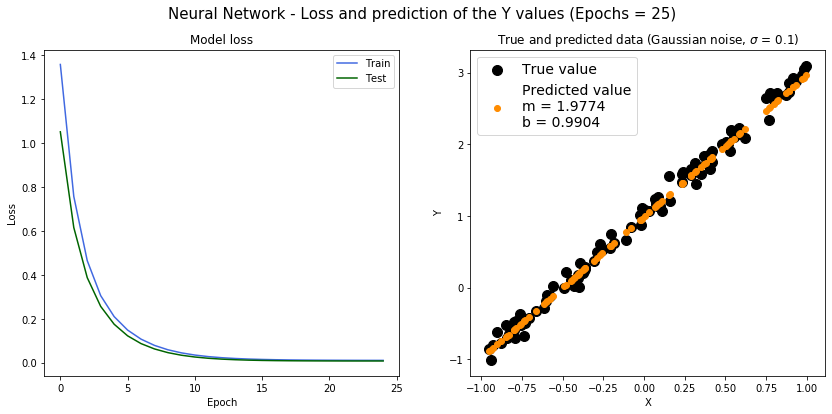

In [3]:
# Fit (Verbose mode set to False by default)
N_batches, N_epochs = 20, 25
Fit_Verbose = False

History, Weights = Fit(N_epochs, N_batches, Fit_Verbose, x_train, y_train, x_valid, y_valid)

# Plots of the output (compared with the true values)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax = ax.flatten()
fig.suptitle(f"Neural Network - Loss and prediction of the Y values (Epochs = {N_epochs})", size=15)

# Plots the loss of History on ax[0]
PlotLoss(History, ax[0]) 

# Plots the output (<N_points> points) with a comparison between true and predicted Y values) on ax[1]
N_points = 100
PlotOutput(xmin, xmax, m, b, sigma, Weights, N_points, ax[1]) 

plt.show()

#  <span style="color:orangered"> Exercise 11.2 </span>
We shall now fit the polynomial 
$$ f(x)=4-3x-2x^2+3x^3, \quad x \in [-1,1]$$<br>
One convenient choice of parameters consists of 40 epochs, 6000 training elements, 600 validation elements. This allows for a relatively fast and accurate fitting, even in presence of gaussian noise with $\sigma = 0.2$. However, it seems that any combination such that 

$$ N_{epochs} \times N_{TrainElem} = const, \quad  N_{ValidElem} \sim \frac{N_{TrainElem}}{10}$$

produces similar results. For instance, in our case $(N_{epochs}, N_{TrainElem}, N_{ValidElem })=(40, 6000, 600)$ performs well, and also $(60, 4000, 400)$ and $(300, 800, 80)$ produce accurate results (in the training domain). Obviously there is no guarantee that this holds for any combination (especially if some extreme choices of parameters are made), but it seems a reasonable conclusion for our specific case. <br>
The actual activation function is *elu*, but also *relu* proved to be effective. Other functions, such as *sigmoid* or *softmax*, are inadequate, because the algorithm gets stuck far from the result we seek. <br>
<span style="color:firebrick"> **NOTE** that the following code is designed as to allow for a quick generalization to any polynomial (of any degree): indeed, the array **a** contains the coefficients of the polynomial and neither its length nor its value are restricted. </span>

In [4]:
###################    FUNCTION DEFINITION     ###################    

def GenData(a, xmin, xmax, Ntrain, Nval, Npred, sigma):
    x_train = np.random.uniform(xmin, xmax, Ntrain)
    x_val = np.random.uniform(xmin, xmax, Nval)
    x_pred = np.random.uniform(xmin, xmax, Npred)
    x_val.sort()
    x_pred.sort()
    # y_train, y_val, y_exact (the latter generated with x_pred)
    y_exact, y_train, y_val = a[0], a[0], a[0]
    for i in range(1, len(a)):
        y_train += a[i]*(x_train**i)
        y_val += a[i]*(x_val**i)
        y_exact += a[i]*(x_pred**i) 
    y_train = np.random.normal(y_train, sigma)
    y_val = np.random.normal(y_val, sigma)
    # Monomials y_k = a_k * x^k
    y_k_train, y_k_val, y_k_pred = [[[] for i in range(len(a))] for i in range(3)]
    for i in range(len(a)):
        y_k_train[i] = a[i]*(x_train**i)
        y_k_val[i] = a[i]*(x_val**i)
        y_k_pred[i] = a[i]*(x_pred**i)
    # DataFrames (pandas) which contain all the relevant arrays
    dict_val = {'x': x_val, 'y': y_val}
    dict_train = {'x': x_train, 'y': y_train}
    dict_pred = {'x': x_pred}
    for i in range(len(a)):
        dict_val['y'+str(i)] = y_k_val[i]
        dict_train['y'+str(i)] = y_k_train[i]
        dict_pred['y'+str(i)] = y_k_pred[i]
    DF_train = pd.DataFrame(data = dict_train) 
    DF_val = pd.DataFrame(data = dict_val)
    DF_pred = pd.DataFrame(data = dict_pred)
    return DF_train, DF_val, DF_pred, y_exact


def InitModel(a):
    Model = tf.keras.Sequential()
    Model.add(Dense(1, input_shape=[len(a)], activation='elu'))
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    opt = keras.optimizers.Adam(learning_rate = 2e-3)
    Model.compile(optimizer=opt, loss="mse")
    return Model, callback


def Fit(a, Model, callback, DF_train, DF_val, Nepochs, Verbose):
    History = Model.fit( x = DF_train[['y'+str(k) for k in range(len(a))]], y = DF_train['y'], epochs = Nepochs, 
                         shuffle = True, verbose = Verbose, callbacks = callback, 
                         validation_data = (DF_val[['y'+str(k) for k in range(len(a))]], DF_val['y']) )
    return History, Model.get_weights()


def Plot(a, Model, History, DF_val, DF_pred, Nepochs, Ntrain, Nval, sigma):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    ax = ax.flatten()
    fig.suptitle(f"Neural Network - Loss and prediction of the Y values ({Nepochs} epochs)", y=0.99, size=16)
    # Loss function
    ax[0].plot(History.history['loss'], color="tab:green", linewidth=2.5)
    ax[0].plot(History.history['val_loss'], color="tab:orange", linewidth=2.5)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_title(fr"Loss, #train = {Ntrain}, #valid = {Nval}, $\sigma_{{noise}}$={sigma}", fontsize=14)
    ax[0].legend(['Train', 'Test'], loc='best', prop={"size":14})
    # Prediction
    ax[1].plot(DF_pred['x'], y_exact, label='True values', color="tab:orange", linewidth=2.5)
    ax[1].scatter(DF_val['x'], DF_val['y'], color='green',alpha=0.4, s=40, label='Validation data')
    ax[1].set_ylabel('Y')
    ax[1].set_xlabel('X')
    ax[1].scatter(DF_pred['x'], Model.predict(DF_pred[['y'+str(k) for k in range(len(a))]]), color="tab:red", s=60,
                  label='Predicted values')
    ax[1].set_title(f'Predicted and true values', fontsize=14)
    ax[1].legend(loc='best',  prop={"size":13})

Epoch 1/40
188/188 [==============================] - 1s 6ms/step - loss: 7.7964 - val_loss: 4.0447
Epoch 2/40
188/188 [==============================] - 1s 6ms/step - loss: 2.0725 - val_loss: 1.0981
Epoch 3/40
188/188 [==============================] - 1s 6ms/step - loss: 0.8432 - val_loss: 0.6469
Epoch 4/40
188/188 [==============================] - 1s 4ms/step - loss: 0.5507 - val_loss: 0.4318
Epoch 5/40
188/188 [==============================] - 1s 5ms/step - loss: 0.3651 - val_loss: 0.2845
Epoch 6/40
188/188 [==============================] - 1s 4ms/step - loss: 0.2375 - val_loss: 0.1858
Epoch 7/40
188/188 [==============================] - 1s 7ms/step - loss: 0.1543 - val_loss: 0.1252
Epoch 8/40
188/188 [==============================] - 1s 8ms/step - loss: 0.1031 - val_loss: 0.0873
Epoch 9/40
188/188 [==============================] - 1s 6ms/step - loss: 0.0731 - val_loss: 0.0663
Epoch 10/40
188/188 [==============================] - 1s 6ms/step - loss: 0.0565 - val_loss: 0.0550

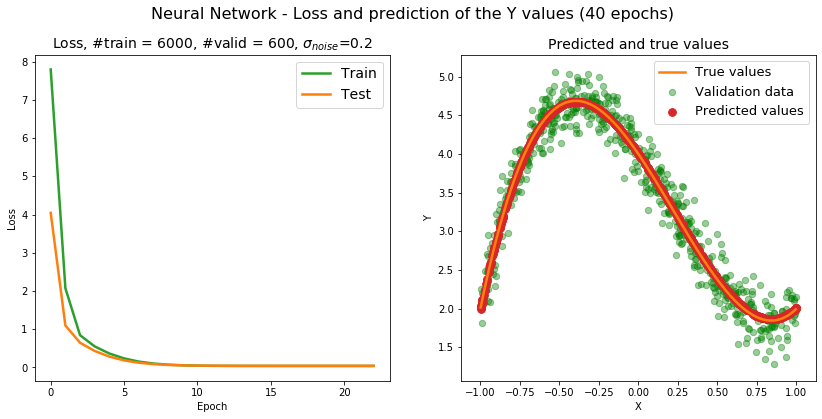

In [5]:
# System parameters. f(x) = a_0 + a_1*x^1 + ... a_N*x^N
a = [4, -3, -2, 3]
xmin, xmax = -1, 1
Ntrain, Nval, Npred = 6000, 600, 600
Nepochs = 40
sigma = 0.2
np.random.seed(0)
Verbose = True    # Set the Model.fit verbose attribute

# Initialize, Generate data and Fit
Model, callback = InitModel(a)
DF_train, DF_val, DF_pred, y_exact = GenData(a, xmin, xmax, Ntrain, Nval, Npred, sigma)
History, Weights = Fit(a, Model, callback, DF_train, DF_val, Nepochs, Verbose)

# Print the weights
print("Weights:")
for i in range(len(Weights[0])):
    print("["+str(i+1)+"] = "+str(float(Weights[0][i])))
    
# Plot
Plot(a, Model, History, DF_val, DF_pred, Nepochs, Ntrain, Nval, sigma)
plt.show()

###  <span style="color:green"> Same polynomial, trying to predict out of the training domain </span>
We now try to predict the behaviour of the same polynomial, but on the domain $[-5,8]$ which extends the training domain.

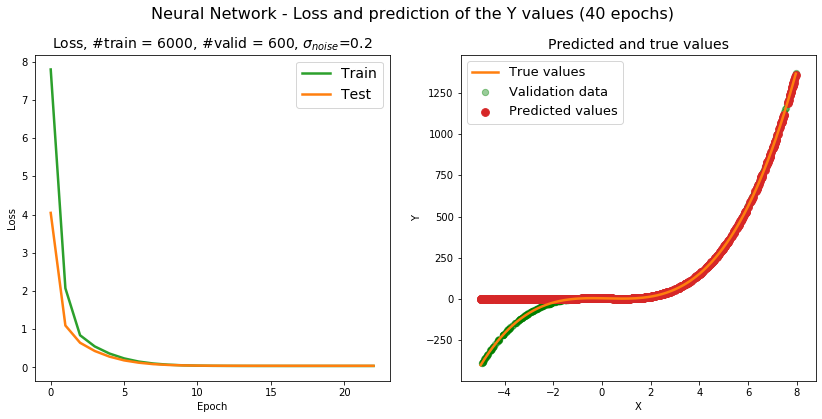

In [6]:
# System parameters. f(x) = a_0 + a_1*x^1 + ... a_N*x^N
xmin, xmax = -5, 8
Ntrain, Nval, Npred = 6000, 600, 600
Nepochs = 40
sigma = 0.2

# Initialize, Generate data and Fit
DF_train, DF_val, DF_pred, y_exact = GenData(a, xmin, xmax, Ntrain, Nval, Npred, sigma)

# Plot
Plot(a, Model, History, DF_val, DF_pred, Nepochs, Ntrain, Nval, sigma)
plt.show()

We see that the algorithm is still accurate for higher values of $x$, whereas for $x<-1$ it fails to reproduce the behaviour of our polynomial. However, this asimmetry is reversed by changing the sign of the leading term of the polynomial.

###  <span style="color:green"> Another polynomial </span>
We show also the fitting of the polynomial 

$$ f(x)=4-3x-2x^2+3x^3+5x^4-0.1x^5, \quad x \in [-1,1.3]$$

using the same code. 

Epoch 1/280
24/24 [==============================] - 1s 21ms/step - loss: 40.4308 - val_loss: 39.6182
Epoch 2/280
24/24 [==============================] - 0s 15ms/step - loss: 36.8506 - val_loss: 35.8924
Epoch 3/280
24/24 [==============================] - 0s 14ms/step - loss: 33.3517 - val_loss: 32.4841
Epoch 4/280
24/24 [==============================] - 0s 13ms/step - loss: 30.1695 - val_loss: 29.3998
Epoch 5/280
24/24 [==============================] - 0s 10ms/step - loss: 27.3030 - val_loss: 26.6090
Epoch 6/280
24/24 [==============================] - 0s 9ms/step - loss: 24.6910 - val_loss: 24.1307
Epoch 7/280
24/24 [==============================] - 0s 18ms/step - loss: 22.2958 - val_loss: 21.8711
Epoch 8/280
24/24 [==============================] - 0s 8ms/step - loss: 20.0112 - val_loss: 19.7094
Epoch 9/280
24/24 [==============================] - 0s 6ms/step - loss: 17.8090 - val_loss: 17.5603
Epoch 10/280
24/24 [==============================] - 0s 7ms/step - loss: 15.5671 - v

24/24 [==============================] - 0s 6ms/step - loss: 0.3273 - val_loss: 0.3205
Epoch 83/280
24/24 [==============================] - 0s 6ms/step - loss: 0.3217 - val_loss: 0.3149
Epoch 84/280
24/24 [==============================] - 0s 6ms/step - loss: 0.3163 - val_loss: 0.3091
Epoch 85/280
24/24 [==============================] - 0s 11ms/step - loss: 0.3110 - val_loss: 0.3038
Epoch 86/280
24/24 [==============================] - 0s 9ms/step - loss: 0.3057 - val_loss: 0.2985
Epoch 87/280
24/24 [==============================] - 0s 7ms/step - loss: 0.3005 - val_loss: 0.2928
Epoch 88/280
24/24 [==============================] - 0s 5ms/step - loss: 0.2954 - val_loss: 0.2876
Epoch 89/280
24/24 [==============================] - 0s 6ms/step - loss: 0.2907 - val_loss: 0.2818
Epoch 90/280
24/24 [==============================] - 0s 5ms/step - loss: 0.2855 - val_loss: 0.2769
Epoch 91/280
24/24 [==============================] - 0s 7ms/step - loss: 0.2804 - val_loss: 0.2723
Epoch 92/280

24/24 [==============================] - 0s 14ms/step - loss: 0.0810 - val_loss: 0.0702
Epoch 164/280
24/24 [==============================] - 0s 17ms/step - loss: 0.0801 - val_loss: 0.0692
Epoch 165/280
24/24 [==============================] - 0s 7ms/step - loss: 0.0790 - val_loss: 0.0682
Epoch 166/280
24/24 [==============================] - 0s 12ms/step - loss: 0.0782 - val_loss: 0.0676
Epoch 167/280
24/24 [==============================] - 0s 13ms/step - loss: 0.0773 - val_loss: 0.0665
Epoch 168/280
24/24 [==============================] - 0s 11ms/step - loss: 0.0763 - val_loss: 0.0657
Epoch 169/280
24/24 [==============================] - 0s 10ms/step - loss: 0.0756 - val_loss: 0.0649
Epoch 170/280
24/24 [==============================] - 0s 11ms/step - loss: 0.0748 - val_loss: 0.0641
Epoch 171/280
24/24 [==============================] - 0s 15ms/step - loss: 0.0741 - val_loss: 0.0633
Epoch 172/280
24/24 [==============================] - 0s 8ms/step - loss: 0.0733 - val_loss: 0.0

24/24 [==============================] - 0s 12ms/step - loss: 0.0472 - val_loss: 0.0364
Epoch 244/280
24/24 [==============================] - 0s 12ms/step - loss: 0.0472 - val_loss: 0.0361
Epoch 245/280
24/24 [==============================] - 0s 12ms/step - loss: 0.0470 - val_loss: 0.0359
Epoch 246/280
24/24 [==============================] - 0s 8ms/step - loss: 0.0468 - val_loss: 0.0357
Epoch 247/280
24/24 [==============================] - 0s 12ms/step - loss: 0.0465 - val_loss: 0.0356
Epoch 248/280
24/24 [==============================] - 0s 12ms/step - loss: 0.0463 - val_loss: 0.0354
Epoch 249/280
24/24 [==============================] - 0s 14ms/step - loss: 0.0462 - val_loss: 0.0352
Epoch 250/280
24/24 [==============================] - 0s 8ms/step - loss: 0.0460 - val_loss: 0.0351
Epoch 251/280
24/24 [==============================] - 0s 10ms/step - loss: 0.0460 - val_loss: 0.0348
Epoch 252/280
24/24 [==============================] - 0s 12ms/step - loss: 0.0457 - val_loss: 0.0

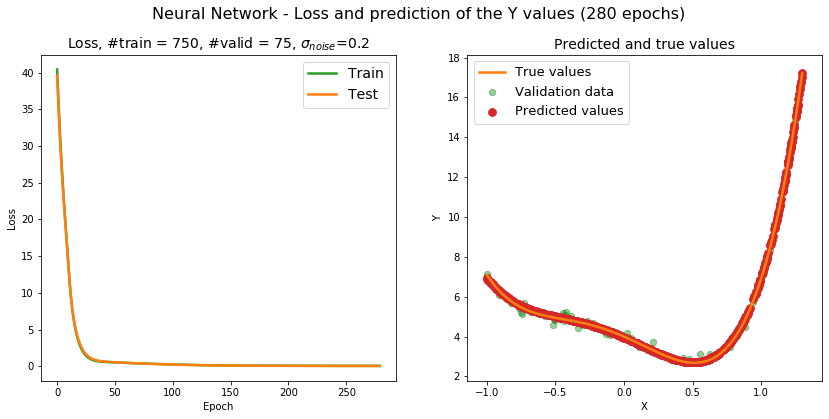

In [7]:
# target parameters of f(x) = a_0 + a_1*x^1 + ... a_N*x^N
a = [4, -3, -2, 3, 5, -0.1]
xmin, xmax = -1, 1.3
Ntrain, Nval, Npred = 750, 75, 600
Nepochs = 280
sigma = 0.2
Verbose = True
np.random.seed(0)

# Initialize, Generate data and Fit
Model, callback = InitModel(a)
DF_train, DF_val, DF_pred, y_exact = GenData(a, xmin, xmax, Ntrain, Nval, Npred, sigma)
History, Weights = Fit(a, Model, callback, DF_train, DF_val, Nepochs, Verbose)

# Plot
Plot(a, Model, History, DF_val, DF_pred, Nepochs, Ntrain, Nval, sigma)
plt.show()

#  <span style="color:orangered"> Exercise 11.3 </span>

Before proceeding with the computation, we notice that the function we are going to fit can be written in the following way:
$$ \mathrm{sin(x^2+y^2) = sin(x^2)cos(y^2) + cos(x^2)sin(y^2)} $$
This enables to split $\mathrm{sin(x^2+y^2)}$ into two independent terms, namely $\mathrm{sin(x^2)cos(y^2)}$ and $\mathrm{cos(x^2)sin(y^2)}$, which enter the equation as linear terms. Therefore, if we train the algorithm to recognize a set of points:
$$ \{(p, q)\},\quad p = \mathrm{sin(x^2)cos(y^2)}, \thinspace q = \mathrm{cos(x^2)sin(y^2)}$$
generated from the set $\{x, y\}$, we are able to fit the functions with a neural network composed of only two neurons. By default, the number of epochs is 30.

In [8]:
import math
from mpl_toolkits.mplot3d import Axes3D

xmin, xmax = -1.5, 1.5
ymin, ymax = -1.5, 1.5
Ntrain, Nvalid, Npred = 10000, 1000, 1000
Nepochs = 30
sigma = 0.0
np.random.seed(0)

x_train = np.random.uniform(xmin, xmax, Ntrain)
x_val = np.random.uniform(xmin, xmax, Nvalid)
x_pred = np.random.uniform(xmin, xmax, Npred)

y_train = np.random.uniform(ymin, ymax, Ntrain)
y_val = np.random.uniform(ymin, ymax, Nvalid)
y_pred = np.random.uniform(ymin, ymax, Npred)

p_train, p_val, p_pred, q_train, q_val, q_pred, z_train, z_val = [[] for i in range(8)]
for i in range(Ntrain):
    p_train.append(math.sin(x_train[i]**2)*math.cos(y_train[i]**2))
    q_train.append(math.sin(y_train[i]**2)*math.cos(x_train[i]**2))
    z_train.append(math.sin(x_train[i]**2+y_train[i]**2))
for i in range(Nvalid):
    p_val.append(math.sin(x_val[i]**2)*math.cos(y_val[i]**2))
    q_val.append(math.sin(y_val[i]**2)*math.cos(x_val[i]**2))
    z_val.append(math.sin(x_val[i]**2+y_val[i]**2))
for i in range(Npred):
    p_pred.append(math.sin(x_pred[i]**2)*math.cos(y_pred[i]**2))
    q_pred.append(math.sin(y_pred[i]**2)*math.cos(x_pred[i]**2))
    
z_train = np.random.normal(z_train, sigma)
z_val = np.random.normal(z_val, sigma)

dict_train = {'p': p_train, 'q': q_train, 'z': z_train}
dict_val = {'p': p_val, 'q': q_val, 'z': z_val}
dict_pred = {'p': p_pred, 'q': q_pred}
DF_train = pd.DataFrame(data=dict_train)
DF_val = pd.DataFrame(data=dict_val)
DF_pred = pd.DataFrame(data=dict_pred)

###  <span style="color:green"> Training </span>
We are now in the position to train the neural network by feeding it with the arrays *p* and *q*.

In [9]:
Verbose = True

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=[2],activation='elu'))# primo layer quindi devo specificare l'input del layer
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
opt = keras.optimizers.Adam(learning_rate = 2e-3)
model.compile(optimizer=opt, loss="mean_squared_error")
history = model.fit(x = DF_train[['p', 'q']], y = z_train, epochs = Nepochs,
          shuffle = True, validation_data = (DF_val[['p', 'q']], z_val), verbose=Verbose,
          callbacks = callback)
W = model.get_weights()

print("Weights: ")
for i in range(len(W[0])):
    print("["+str(i+1)+"] = "+str(float(W[0][i])))

Epoch 1/30
313/313 [==============================] - 2s 7ms/step - loss: 0.6405 - val_loss: 0.3338
Epoch 2/30
313/313 [==============================] - 1s 4ms/step - loss: 0.2387 - val_loss: 0.1407
Epoch 3/30
313/313 [==============================] - 2s 5ms/step - loss: 0.1175 - val_loss: 0.0743
Epoch 4/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0616 - val_loss: 0.0370
Epoch 5/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0296 - val_loss: 0.0169
Epoch 6/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0134 - val_loss: 0.0072
Epoch 7/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 8/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 9/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0015 - val_loss: 8.1077e-04
Epoch 10/30
313/313 [==============================] - 3s 8ms/step - loss: 0.0011 - val_loss: 6.

###  <span style="color:green"> Results </span>
We then plot the true and predicted values from two different perspectives. The predicted values are generated from two sets *x_pred* and *y_pred*, independent from both the training and validation sets. We can see that true and predicted values agree, however in the next cell we perform a selection of points lying in the region $[0, 1.5]\times[0, 1.5]$, with the aim of making even clearer their affinity.

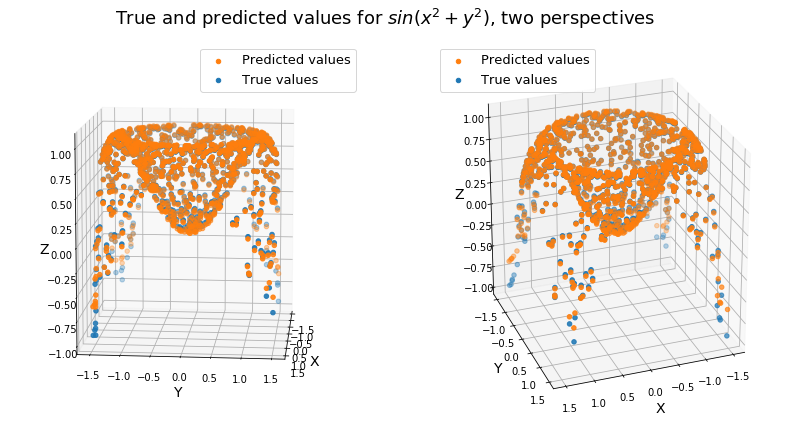

In [10]:
fig = plt.figure(figsize=(14, 7))
ax = [fig.add_subplot(1, 2, i+1, projection='3d') for i in range(0, 2)]
fig.suptitle(r"True and predicted values for $sin(x^2+y^2)$, two perspectives", y = 0.95, size=18)

# First perspective
ax[0].scatter(x_pred, y_pred, model.predict(DF_pred[['p', 'q']]), color="tab:orange", label='Predicted values')
ax[0].scatter(x_pred, y_pred, [math.sin(x_pred[i]**2+y_pred[i]**2) for i in range(len(x_pred))], color="tab:blue",
              label='True values')
ax[0].set_xlabel("X", fontsize=14)
ax[0].set_ylabel("Y", fontsize=14)
ax[0].set_zlabel("Z", fontsize=14)
ax[0].legend(prop={"size":13}, loc="upper right")
# Second perspective
ax[1].scatter(x_pred, y_pred, model.predict(DF_pred[['p', 'q']]), color="tab:orange", label='Predicted values')
ax[1].scatter(x_pred, y_pred, [math.sin(x_pred[i]**2+y_pred[i]**2) for i in range(len(x_pred))], color="tab:blue",
              label='True values')
ax[1].set_xlabel("X", fontsize=14)
ax[1].set_ylabel("Y", fontsize=14)
ax[1].set_zlabel("Z", fontsize=14)
ax[1].legend(prop={"size":13}, loc="upper left")

ax[0].view_init(10, 5)
ax[1].view_init(25, 70)

###  <span style="color:green"> Restriction to $[0, 1.5]\times[0, 1.5]$ </span>

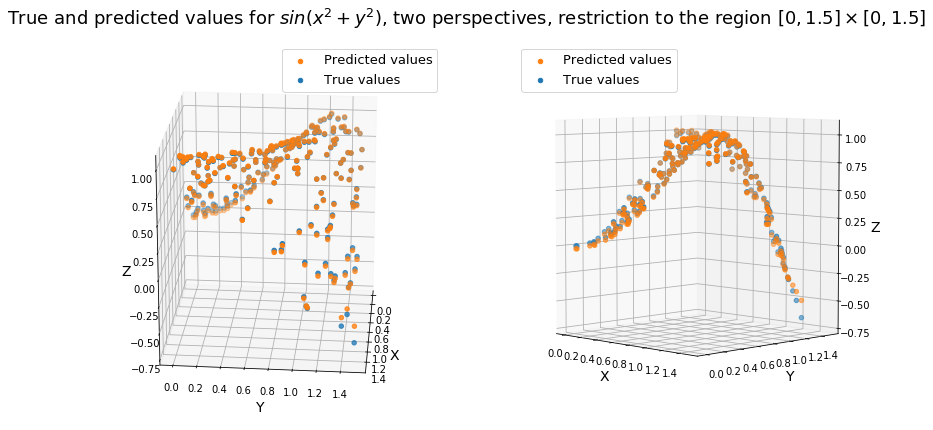

In [11]:
# Select only the points in [0, 1.5]^2
x_pred_new, y_pred_new, p_pred_new, q_pred_new = [], [], [], []
for i in range(Npred):
    if (x_pred[i] > 0 and y_pred[i] > 0):
        x_pred_new.append(x_pred[i])
        y_pred_new.append(y_pred[i])
        p_pred_new.append(math.sin(x_pred[i]**2)*math.cos(y_pred[i]**2))
        q_pred_new.append(math.sin(y_pred[i]**2)*math.cos(x_pred[i]**2))
dict_pred_new = {'p': p_pred_new, 'q': q_pred_new}
DF_pred_new = pd.DataFrame(data=dict_pred_new)

fig = plt.figure(figsize=(14, 7))
ax = [fig.add_subplot(1, 2, i+1, projection='3d') for i in range(0, 2)]
fig.suptitle(r"True and predicted values for $sin(x^2+y^2)$, two perspectives, "+
             r"restriction to the region $[0, 1.5]\times[0, 1.5]$", y = 0.95, size=18)

# First perspective
ax[0].scatter(x_pred_new, y_pred_new, model.predict(DF_pred_new[['p', 'q']]), color="tab:orange", 
              label='Predicted values')
ax[0].scatter(x_pred_new, y_pred_new, [math.sin(x_pred_new[i]**2+y_pred_new[i]**2) for i in range(len(x_pred_new))], 
              color="tab:blue", label='True values')
ax[0].set_xlabel("X", fontsize=14)
ax[0].set_ylabel("Y", fontsize=14)
ax[0].set_zlabel("Z", fontsize=14)
ax[0].legend(prop={"size":13}, loc="upper right")
# Second perspective
ax[1].scatter(x_pred_new, y_pred_new, model.predict(DF_pred_new[['p', 'q']]), color="tab:orange", 
              label='Predicted values')
ax[1].scatter(x_pred_new, y_pred_new, [math.sin(x_pred_new[i]**2+y_pred_new[i]**2) for i in range(len(x_pred_new))], 
              color="tab:blue", label='True values')
ax[1].set_xlabel("X", fontsize=14)
ax[1].set_ylabel("Y", fontsize=14)
ax[1].set_zlabel("Z", fontsize=14)
ax[1].legend(prop={"size":13}, loc="upper left")

ax[0].view_init(20, 5)
ax[1].view_init(5, -45)